In [7]:
#Celso Henrique
# Import all necessary libraries.
import numpy as np
from scipy.special import erfc
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
# Number of QPSK symbols to be transmitted.

N = 1000

In [9]:
mapping_table = [-3-3j, -3-1j, -3+3j, -3+1j, -1-3j, -1-1j, -1+3j, -1+1j, 3-3j, 3-1j, 3+3j, 3+1j, 1-3j,
1-1j, 1+3j, 1+1j]

def mod(bits):
    symbols = np.zeros((len(bits),),dtype=complex)
    for i in range(0,len(bits)): 
        symbols[i] = mapping_table[bits[i]]/np.sqrt(10)
    return symbols

def demod(c):
    c_seq = mod(np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]))
    c_seq = c_seq.reshape(16,1)
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

In [10]:
# Generate N 4-bit symbols.
bits = np.random.randint(0,16,N)

# Modulate the binary stream into 16QAM symbols.
symbols = mod(bits)

symbols = symbols.reshape(-1,1)


In [29]:
# Create Es/N0 vector.

EsN0dB = np.arange(-2,22,2)
ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))

for idx in range(0,len(EsN0dB)):
    print('Es/N0 dB:', EsN0dB[idx])
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
    erro=0
    
    # Generate noise vector with unitary variance.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))

    # Pass symbols through AWGN channel.
    y = symbols + np.sqrt(EsN0Lin)*noise

    s_test, s_train, y_test, y_train, v_test, v_train = train_test_split(symbols, y, bits, random_state=20)

    Y = np.c_[y_train.real,y_train.imag]
    
    kmm = KMeans(n_clusters=16, random_state=20)
    kmm.fit(Y)
    
    detect = kmm.predict(np.c_[y_test.real,y_test.imag]) 
    
    for i in range(0,len(v_test)):
        predito = kmm.cluster_centers_[detect[i],0] + 1j*kmm.cluster_centers_[detect[i],1]
        predito = demod(predito)
        if((v_test[i] != predito)==True): 
            erro = erro + 1
    
    ser_simu[idx] = 1.0 * erro / N

    
    
    M=16
    k = np.sqrt(3/(2*(M-1)))
    
    # Theoretical BPSK BER.
    ser_theo[idx] = 2*(1-1/np.sqrt(M))*erfc(k*np.sqrt(10.0**(EsN0dB[idx]/10.0)))-(1-(2/np.sqrt(M))+(1/M))*np.square(erfc(k*np.sqrt(10.0**(EsN0dB[idx]/10.0))))

Es/N0 dB: -2
Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10
Es/N0 dB: 12
Es/N0 dB: 14
Es/N0 dB: 16
Es/N0 dB: 18
Es/N0 dB: 20


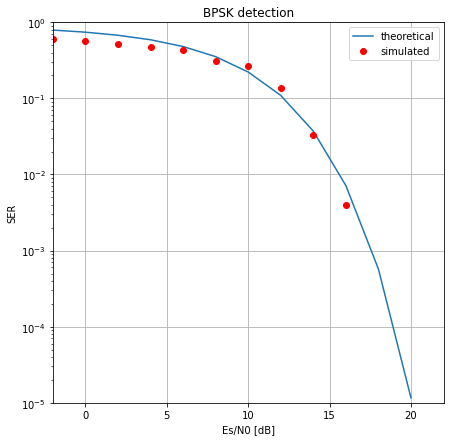

In [30]:
# Plot Es/N0 versus BER values.
fig = plt.figure(figsize=(7,7))
plt.plot(EsN0dB, ser_theo, label='theoretical')
plt.plot(EsN0dB, ser_simu, 'ro', label='simulated')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.title('BPSK detection')
plt.legend()
plt.xlim([-2, 22])
plt.ylim([1e-5, 1])
plt.show()